In [2]:
from load_sim_data import *
from load_shp import *
from sim_eval_pkg import *

___

### Fig 3a

___


=== CORRELATION WITH OBSERVATIONS ===
Control run correlation: 0.849
Test run correlation:    0.868

=== MEAN ABSOLUTE ERROR ===
Control run MAE: 4.512 K
Test run MAE:    2.620 K

=== DATA RANGE ===
CTRL_UHR    302.036  290.438  313.519    3.545
USURF_UHR   299.956  288.572  317.899    3.738
MODIS       297.706  284.812  317.666    3.753


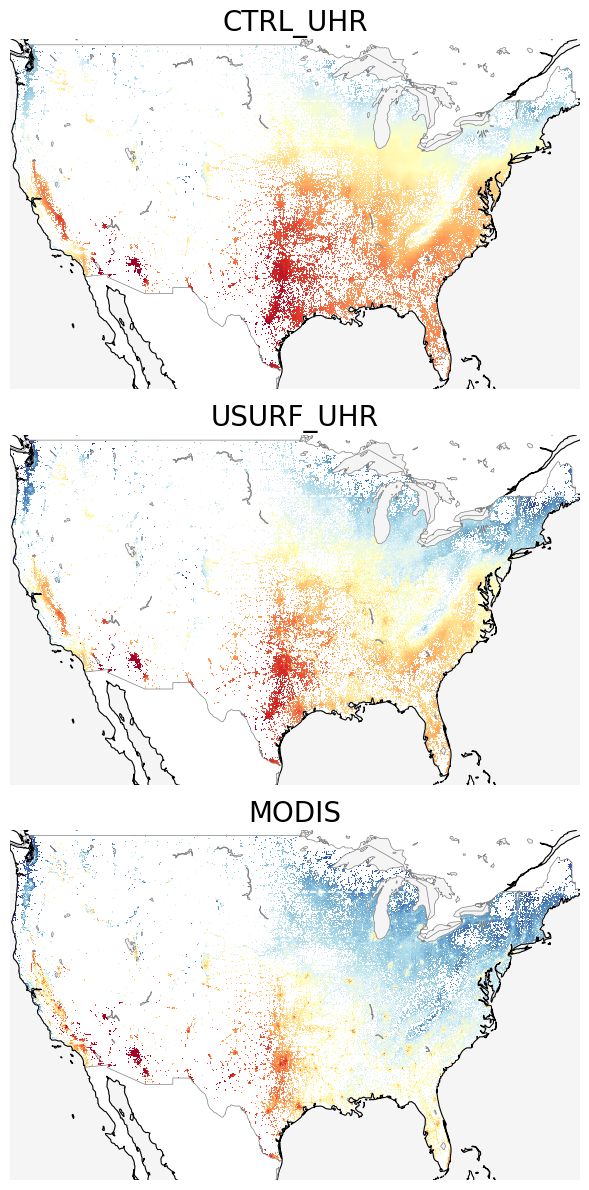

In [3]:
conus_obs = clip_netcdf_by_shp(MODIS_SUMM_LST_avg.LST,us_bounds)
conus_ctrl = clip_netcdf_by_shp(ctrl_JJA_avg_1d32deg['TSKIN_U'],us_bounds)
conus_test = clip_netcdf_by_shp(test_JJA_avg_1d32deg['TSKIN_U'],us_bounds)

valid_mask = np.isfinite(conus_ctrl) & np.isfinite(conus_obs) & np.isfinite(conus_test)
conus_obs = conus_obs.where(valid_mask)
conus_ctrl = conus_ctrl.where(valid_mask)
conus_test = conus_test.where(valid_mask)

datasets = [conus_ctrl, conus_test, conus_obs]
dataset_names = ["CTRL_UHR", "USURF_UHR", "MODIS"]

plot_config = {
    'vmin': 290,         
    'vmax': 310,
    'cmap': 'RdYlBu_r',
    'figsize': (6, 12),
    'conus_extent': [-125, -66.5, 24, 50]
}

fig, axs = plt.subplots(3, 1, 
                       figsize=plot_config['figsize'], 
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)})

for ax, data, title in zip(axs, datasets, dataset_names):
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    data.plot(
        ax=ax,
        transform=ccrs.PlateCarree(),
        cmap=plot_config['cmap'], 
        vmax=plot_config['vmax'],
        vmin=plot_config['vmin'],
        alpha=1,
        add_colorbar=False
    )
    
    ax.coastlines(color='black', linewidth=0.8)
    ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=150)
    ax.add_feature(cfeature.OCEAN, color='whitesmoke', zorder=1)
    ax.add_feature(cfeature.LAKES, edgecolor='gray', facecolor='whitesmoke', 
                   linewidth=0.5, zorder=50)

    gl = ax.gridlines(draw_labels=False, color='white', linewidth=1.2, 
                      linestyle='--', zorder=3)
    gl.xlocator = plt.FixedLocator([-100, 0, 100])
    gl.ylocator = plt.FixedLocator([-90, -45, 0, 45, 90])
    
    ax.set_title(title, fontsize=20)
    ax.set_aspect('auto')

fig.tight_layout() 
fig.savefig(plot_path+'MODIS_TSKINU_2010_2014_JJA_CTRL_TEST_CONUS_USurf_masked_c250711.png', format='png', bbox_inches='tight', dpi=600)

ctrl = conus_ctrl.values.flatten()
test = conus_test.values.flatten()
obs  = conus_obs.values.flatten()

flat_valid_mask = np.isfinite(ctrl) & np.isfinite(test) & np.isfinite(obs)
conus_ctrl_clean = ctrl[flat_valid_mask]
conus_test_clean = test[flat_valid_mask]
conus_obs_clean  = obs[flat_valid_mask]

print("\n=== CORRELATION WITH OBSERVATIONS ===")
ctrl_corr = np.corrcoef(conus_ctrl_clean, conus_obs_clean)[0, 1]
test_corr = np.corrcoef(conus_test_clean, conus_obs_clean)[0, 1]
print(f"Control run correlation: {ctrl_corr:.3f}")
print(f"Test run correlation:    {test_corr:.3f}")

print("\n=== MEAN ABSOLUTE ERROR ===")
ctrl_mae = np.mean(np.abs(conus_ctrl_clean - conus_obs_clean))
test_mae = np.mean(np.abs(conus_test_clean - conus_obs_clean))
print(f"Control run MAE: {ctrl_mae:.3f} K")
print(f"Test run MAE:    {test_mae:.3f} K")

print("\n=== DATA RANGE ===")
for data, name in zip(datasets, dataset_names):
    mean_val = np.nanmean(data)
    std_val = np.nanstd(data)
    min_val = np.nanmin(data)
    max_val = np.nanmax(data)
    print(f"{name:<10} {mean_val:>8.3f} {min_val:>8.3f} {max_val:>8.3f} {std_val:>8.3f}")

___

### Fig 3b

___

In [3]:
def plot_city_temperature_comparison(ctrl_data, test_data, obs_data, 
                                   city_shapefile, city_name,
                                   gridspec_kw=None,
                                   temp_ranges=None,
                                   figsize=(18, 9),
                                   ax_aspect='equal'):
    city_ctrl = clip_netcdf_by_shp(ctrl_data, city_shapefile)
    city_test = clip_netcdf_by_shp(test_data, city_shapefile)
    city_obs = clip_netcdf_by_shp(obs_data, city_shapefile)

    fig, axs = plt.subplots(1, 3, figsize=figsize, 
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude=0)},
                           gridspec_kw=gridspec_kw)
    
    datasets = [city_ctrl, city_test, city_obs]
    titles = ["CTRL", "TEST", "MODIS"]

    for ax, data, title, (vmin, vmax) in zip(axs, datasets, titles, temp_ranges):
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        data.plot(
            ax=ax,
            transform=ccrs.PlateCarree(),
            cmap='RdYlBu_r', 
            vmax=vmax,
            vmin=vmin,
            alpha=1,
            add_colorbar=False
        )

        ax.add_geometries([city_shapefile], ccrs.PlateCarree(), 
                          edgecolor='black', facecolor='none', 
                          linewidth=1.5, zorder=200)
        
        ax.coastlines(color='black', linewidth=0.8)
        ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth=0.5, zorder=150)
        ax.add_feature(cfeature.OCEAN, color='whitesmoke', zorder=1)
        
        gl = ax.gridlines(draw_labels=False, color='white', 
                          linewidth=1.2, linestyle='--', zorder=3)
        gl.xlocator = plt.FixedLocator([-100, 0, 100])
        gl.ylocator = plt.FixedLocator([-90, -45, 0, 45, 90])

        ax.set_title('')
        ax.set_aspect(ax_aspect)

    fig.tight_layout()
        
    city_data = {
        'ctrl': city_ctrl,
        'test': city_test,
        'obs': city_obs
    }

    ctrl = city_ctrl.values.flatten()
    test = city_test.values.flatten()
    obs  = city_obs.values.flatten()
    
    flat_valid_mask = np.isfinite(ctrl) & np.isfinite(test) & np.isfinite(obs)
    city_ctrl_clean = ctrl[flat_valid_mask]
    city_test_clean = test[flat_valid_mask]
    city_obs_clean  = obs[flat_valid_mask]
    
    print("\n=== CORRELATION WITH OBSERVATIONS ===")
    ctrl_corr = np.corrcoef(city_ctrl_clean, city_obs_clean)[0, 1]
    test_corr = np.corrcoef(city_test_clean, city_obs_clean)[0, 1]
    print(f"Control run correlation: {ctrl_corr:.3f}")
    print(f"Test run correlation:    {test_corr:.3f}")
    
    print("\n=== MEAN ABSOLUTE ERROR ===")
    ctrl_mae = np.mean(np.abs(city_ctrl_clean - city_obs_clean))
    test_mae = np.mean(np.abs(city_test_clean - city_obs_clean))
    print(f"Control run MAE: {ctrl_mae:.3f} K")
    print(f"Test run MAE:    {test_mae:.3f} K")

    print("\n=== DATA RANGE ===")
    for data, name in zip(datasets, titles):
        mean_val = np.nanmean(data)
        std_val = np.nanstd(data)
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)
        print(f"{name:<10} {mean_val:>8.3f} {min_val:>8.3f} {max_val:>8.3f} {std_val:>8.3f}")
    return fig, city_data

In [4]:
def create_standalone_colorbar(vmin, vmax, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=None, tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='left',
                             extend='neither'):
    fig = plt.figure(figsize=figsize)
    
    if orientation == 'vertical':
        ax_pos = [0.05, 0.5, 0.9, 0.3]  
    else: 
        ax_pos = [0.5, 0.05, 0.3, 0.9]
    
    ax = fig.add_axes(ax_pos)

    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    
    cb = plt.colorbar(sm, cax=ax, orientation=orientation, 
                      extend=extend, ticklocation=ticklocation)
    
    cb.outline.set_visible(False)
    
    if tick_values is not None:
        cb.set_ticks(tick_values)
        
    cb.ax.tick_params(labelsize=tick_fontsize, pad=2)
    
    if label:
        cb.set_label(label, fontsize=label_fontsize, labelpad=10, loc='center')
        if orientation == 'vertical' and ticklocation == 'left':
            cb.ax.yaxis.set_label_position('left')
        elif orientation == 'horizontal' and ticklocation == 'top':
            cb.ax.xaxis.set_label_position('top')

    return fig, cb


=== CORRELATION WITH OBSERVATIONS ===
Control run correlation: 0.394
Test run correlation:    0.809

=== MEAN ABSOLUTE ERROR ===
Control run MAE: 1.605 K
Test run MAE:    0.831 K

=== DATA RANGE ===
CTRL        300.062  298.966  301.590    0.521
TEST        298.926  296.600  301.396    0.936
MODIS       298.766  294.293  302.622    1.619


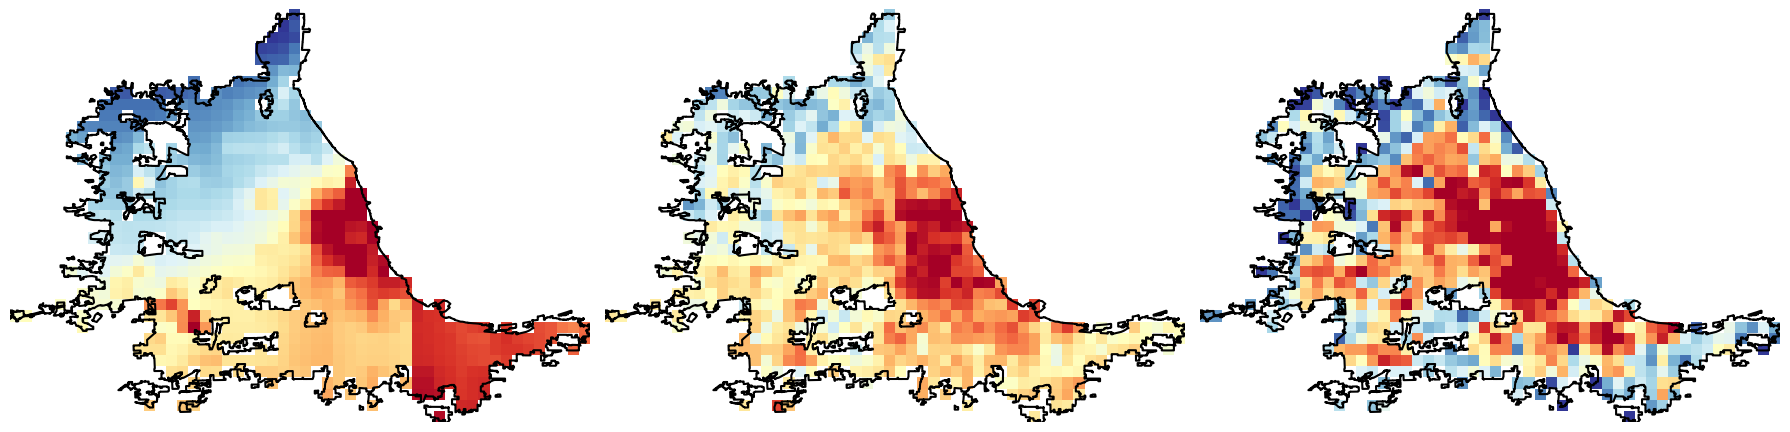

In [6]:
chi_fig, chi_data = plot_city_temperature_comparison(
    ctrl_data=ctrl_JJA_avg_1d32deg.TSKIN_U,
    test_data=test_JJA_avg_1d32deg.TSKIN_U,
    obs_data=MODIS_SUMM_LST_avg.LST,
    city_shapefile=chi_shapefile,
    city_name="Chicago",
    temp_ranges=[(299, 301), (296, 301), (296, 301)]
)
chi_fig.savefig(plot_path+'MODIS_TSKINU_2010_2014_JJA_CTRL_TEST_Chicago_USurf_masked_c250711.png', format='png', bbox_inches='tight', dpi=600)

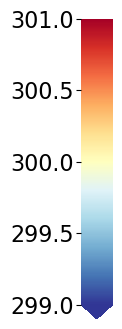

In [54]:
# CTRL colorbar
fig_temp, cb_temp=create_standalone_colorbar(vmin=299, vmax=301, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=None, tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='left',
                             extend='min')

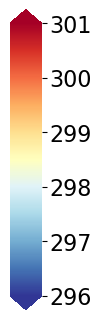

In [55]:
# USURF & MODIS colorbar
fig_temp, cb_temp=create_standalone_colorbar(vmin=296, vmax=301, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=None, tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='right',
                             extend='both')

___

### Fig 3c

___


=== CORRELATION WITH OBSERVATIONS ===
Control run correlation: 0.183
Test run correlation:    0.747

=== MEAN ABSOLUTE ERROR ===
Control run MAE: 3.267 K
Test run MAE:    0.894 K

=== DATA RANGE ===
CTRL        299.186  298.247  300.024    0.373
TEST        296.378  294.772  299.797    0.882
MODIS       295.969  290.731  300.812    1.521


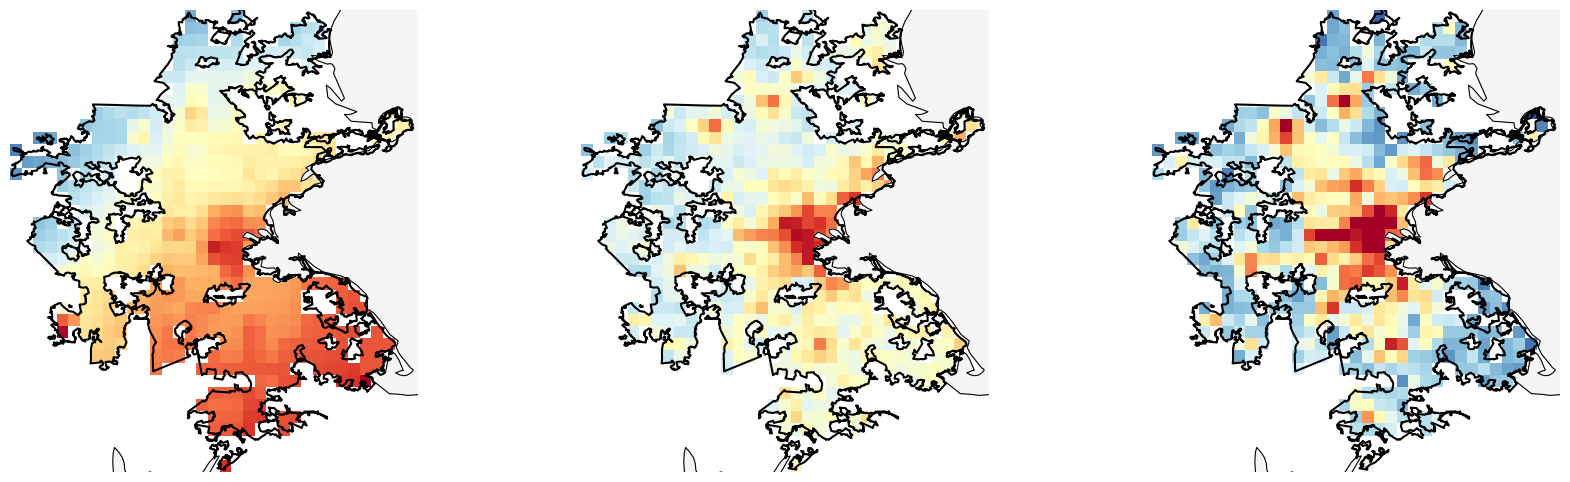

In [7]:
# Figure 3c
bos_fig, bos_data = plot_city_temperature_comparison(
    ctrl_data=ctrl_JJA_avg_1d32deg.TSKIN_U,
    test_data=test_JJA_avg_1d32deg.TSKIN_U,
    obs_data=MODIS_SUMM_LST_avg.LST,
    city_shapefile=bos_shapefile,
    city_name="Boston",
    gridspec_kw={'wspace': 0.4, 'hspace': 0},
    temp_ranges=[(298, 300), (293, 300), (293, 300)],
    figsize=(20,6),
    ax_aspect='auto')
bos_fig.savefig(plot_path+'MODIS_TSKINU_2010_2014_JJA_CTRL_TEST_Boston_USurf_masked_c250711.png', format='png', bbox_inches='tight', dpi=600)

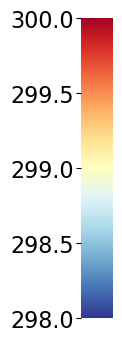

In [63]:
# CTRL colorbar
fig_temp, cb_temp=create_standalone_colorbar(vmin=298, vmax=300, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=None, tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='left',
                             extend='neither')

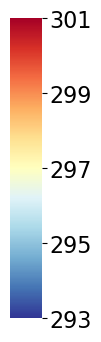

In [64]:
# USURF & MODIF colorbar
fig_temp, cb_temp=create_standalone_colorbar(vmin=293, vmax=301, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=[293,295,297,299,301], tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='right',
                             extend='neither')

___

### Fig 3d

___


=== CORRELATION WITH OBSERVATIONS ===
Control run correlation: -0.006
Test run correlation:    0.587

=== MEAN ABSOLUTE ERROR ===
Control run MAE: 1.856 K
Test run MAE:    1.077 K

=== DATA RANGE ===
CTRL        305.245  304.992  305.679    0.153
TEST        304.322  302.250  305.419    0.619
MODIS       303.427  299.793  305.945    1.361


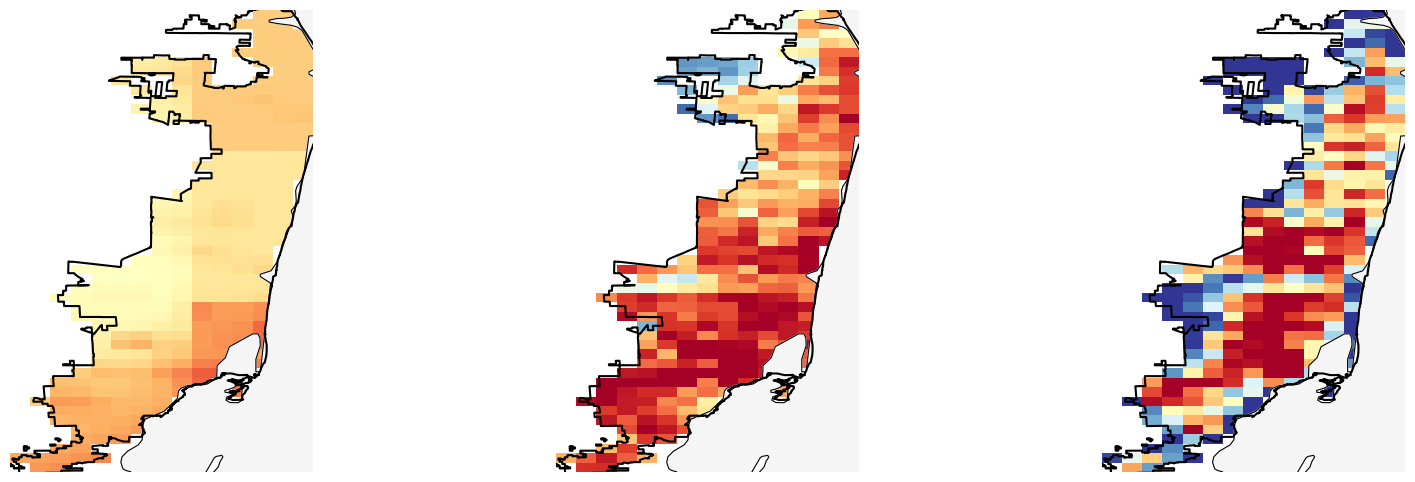

In [11]:
# Figure 3d
mia_fig, mia_data = plot_city_temperature_comparison(
    ctrl_data=ctrl_JJA_avg_1d32deg.TSKIN_U,
    test_data=test_JJA_avg_1d32deg.TSKIN_U,
    obs_data=MODIS_SUMM_LST_avg.LST,
    city_shapefile=mia_shapefile,
    city_name="Miami",
    gridspec_kw={'wspace': 0.8, 'hspace': 0},
    temp_ranges=[(304, 306), (302, 305), (302, 305)],
    figsize=(18,6),
    ax_aspect='auto')
mia_fig.savefig(plot_path+'MODIS_TSKINU_2010_2014_JJA_CTRL_TEST_Miami_USurf_masked_c250711.png', format='png', bbox_inches='tight', dpi=600)

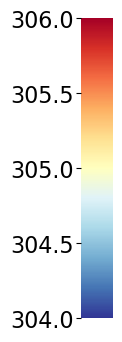

In [61]:
# CTRL colorbar
fig_temp, cb_temp=create_standalone_colorbar(vmin=304, vmax=306, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=None, tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='left',
                             extend='neither')

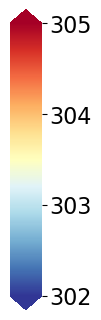

In [60]:
# USURF & MODIS colorbar
fig_temp, cb_temp=create_standalone_colorbar(vmin=302, vmax=305, cmap='RdYlBu_r', 
                             label=None, label_fontsize=16,
                             tick_values=[302,303,304,305], tick_fontsize=16,
                             figsize=(0.35, 10), 
                             orientation='vertical',
                             ticklocation='right',
                             extend='both')